--------------------------------------------------------------------
ER background from materials. 
----------------------------------------------------------------
notebook can be run on the Freiburg cluster or on Dali. 
Change the path of files accordingly.
on dali files are on: /dali/lgrandi/xenonnt/simulations/er_simulations/rootfiles

In [1]:
print("loading....")
%run 'init.ipynb'
%run 'geometry_checks.ipynb'
%run 'functions.ipynb'
print("done!")

loading....
server chosen is: /dali/lgrandi/xenonnt/simulations/er_simulations/rootfiles/
working on: PmtTpc


FileNotFoundError: [Errno 2] No such file or directory: 'Bell.json'

done!


In [2]:
#list of components and isotopes used in this analysis.

components = ["PmtTpc",
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "Teflon_Pillar_",#includes also pfte frame (Lxe + Gxe part)
             "SS_AnodeRing", #anode + all the electrodes 
             "Teflon_TPC_Sliding", #material is Teflon_TPC used twice for sliding and fixed
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             "Copper_TopRing", #includes also bottom ring
             "Copper_FieldGuard_",
              "Copper_FieldShaperRing_",
              "Copper_BottomPmtPlate" #includes also top ring
             ]

isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226"
                ]

In [ ]:
def do(component, m_fv): 
    #main function to calculate the rate
    conv = 3.15*1e7 #conversion factor s->y
    rate_array = []
    error_array = []
    i = 0
    flag = 0
    total_str = ""  
    E = 11
    time_array = []
  
    for i in range(0, len(isotope_array)):
        note = " "
        isotope = isotope_array[i]
        data, frac, material = get_data(isotope, component) 
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #return the normalization for the isotope chains
        n =  N*(frac/100)*(1/b) #n_gen * fraction events in that component * chain_factor
        
        n_events = calculate_events(data, isotope)
        #print("---", isotope, n, N, frac, n_events, b )
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]/1000 #mBq->Bq
        contamination = p[isotope]/1000 
        if error_cont == 0:
            note = "*"
        else:
            note = " "
        if (contamination == 0):
            rate = 0
            error_rate = 0
            str_ = ( "| no contamination value ")
            alpha = 0
            time = 0

        else:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
            #print("----", isotope, time/conv)
            rate = n_events/(time * m_fv ) #*E  #ev/s*kg
            alpha = mass / (m_fv * n) #correct with mass*b/(m_fv*E*N_gen)  ##no energy   
            error_rate = alpha * np.sqrt((n_events * error_cont)**2 + (contamination*np.sqrt(n_events))**2)
            
            if n_events == 2.3: 
                str_ = ("| <%2.2g" %(rate*conv)) + note
                flag = flag +1
            else:
                str_ = ("|(%2.2g +- %2.2g)" %(rate*conv, error_rate*conv))+ note 
            
        rate_array = np.append(rate_array, rate)
        error_array = np.append(error_array, error_rate) 
        total_str = total_str  + str_ 
        
        if time == 0:
            time_array = time_array = np.append(time_array, time)  
        else:
            time_array = time_array = np.append(time_array, time/conv)
        
        i = i+1 
        tot_rate = 0
        tot_error_rate = 0
        if len(rate_array)!=0:
            for i in range(0, len(rate_array)):
                tot_rate = tot_rate + rate_array[i]
                tot_error_rate = tot_error_rate + error_array[i]
                if flag == 0:
                    total_rate_string = ("|(**%2.2g +- %2.2g)" %(tot_rate*conv, tot_error_rate*conv)+ "**|" )
                else:
                    total_rate_string = ("|**<%2.2g " %(tot_rate*conv)+ "**|") 
        else:
            total_rate_string = "|"        
    print("|" + component + total_str + total_rate_string)
    return tot_rate*conv, time_array
    
####################################################################################

In [9]:
#Cell calculates the rate for the Cryostats
m_fv = 4
components = [
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)
    print("^Tot.^^^^^^^^^", "%.2g" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 


^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|OuterCryostat_Elongation|(0.18 +- 0.55) |(0.094 +- 0.069) |(0.045 +- 0.072) |(0.00031 +- 0.00094) |(0.073 +- 0.15) | <0.64*|(0.027 +- 0.12) |(1.5 +- 1.2) |**<2.5 **|
|OuterCryostatShell| <2.3 |(7.2 +- 2.5) |(0.22 +- 0.22)*|(0.026 +- 0.037)*|(0.21 +- 0.21)*| <0.23 |(0.057 +- 0.072) |(1.4 +- 0.82)*|**<12 **|
|OuterCryostat_flanges|(0.032 +- 0.14) |(2.9 +-  3) |(0.46 +- 0.46)*|(0.0068 +- 0.029)*|(0.14 +- 0.61) | <0.12 | <0.2 |(2.9 +-  3)*|**<6.8 **|
|SS_InnerCryostatShell|(0.31 +- 0.59) |(1.4 +- 0.47) |(0.19 +- 0.15) |(0.017 +- 0.015)*|(0.63 +- 0.39) | <1.1 |(0.03 +- 0.039) |(0.19 +- 0.19) |**<3.9 **|
|SS_InnerCryostatFlanges| <2.6 |(12 +- 8.4) |(0.15 +- 0.36)*|(0.04 +- 0.098)*|(0.56 +- 1.7) | <0.24 | <0.39 |(5.8 +- 5.8)*|**<22 **|
|SS_InnerCryostat_bottomDome| <1.1 |(0.00078 +- 0.0033) | <0.074 | <0.0018 | <0.21 | <0.18*| <0.32 | <0.64 |**<2.5 **|
^Tot.^^^^^^^^^ 49 ev/t*y^


working on: OuterCryostat_Elongation


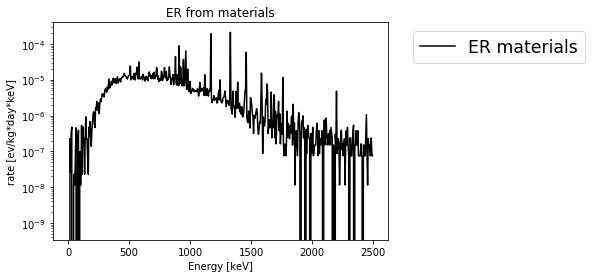

In [11]:
#plot cryostat
components = [
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             ]
values, bins_plt = plot_total_contribution(500, 0, 2500 )
make_spectrum(values, "Cryostat")

In [ ]:
#----------BELL----------------
components = [
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

In [ ]:
#plot Bell
components = [
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             ]
values, bins_plt = plot_total_contribution(500, 0, 2500 )
make_spectrum(values, "Bell")

working on: SS_BellPlate


In [11]:
#-----------Teflon ----------------
components = [
             "Teflon_Pillar_",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|Teflon_Pillar_|(0.0033 +- 0.0031) | no contamination value |(0.0025 +- 0.0018)*|(0.00019 +- 8.6e-05)*|(0.0035 +- 0.0017)*|(0.0016 +- 0.0016)*|(0.0031 +- 0.0022) |(0.0046 +- 0.0023) |(**0.019 +- 0.013)**|
|Teflon_TPC_Sliding|(0.00045 +- 0.00049) | no contamination value |(0.00024 +- 0.00014) |(0.00016 +- 6.7e-05)*|(0.00099 +- 0.00057)*|(0.0077 +- 0.0018)*|(0.00058 +- 0.0004) |(0.0024 +- 0.0015) |(**0.013 +- 0.005)**|
|Teflon_TPC_Fixed|(0.00015 +- 0.00015)*| no contamination value |(0.037 +- 0.017) |(0.00036 +- 0.00015)*|(0.0017 +- 0.00099)*|(0.014 +- 0.0033)*|(0.0038 +- 0.0017) |(0.00079 +- 0.00046)*|(**0.058 +- 0.024)**|
|Teflon_BottomTPC|(2.1e-06 +- 5.2e-06) | no contamination value |(4.8e-05 +- 7.8e-05) |(8.6e-07 +- 1.8e-06)*|(1e-05 +- 7.4e-06)*|(1.4e-05 +- 1.4e-05)*|(5.1e-06 +- 1.1e-05) |(4.1e-05 +- 2e-05)*|(**0.00012 +- 0.00014)**|
^Tot.^^^^^^^^^ 0.0890 ev/t*y^


In [ ]:
#plot Teflon
components = [
             "Teflon_Pillar_",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             ]
values, bins_plt = plot_total_contribution(500, 0, 2500 )
make_spectrum(values, "Teflon")

In [12]:
#-----------Copper ----------------
components = [
             "Copper_TopRing",
             "Copper_FieldGuard_",
             "Copper_FieldShaperRing_",
             "Copper_BottomPmtPlate"
             ]


#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|Copper_TopRing|(0.002 +- 0.006)*|(0.0012 +- 0.00063)*|(0.00081 +- 0.002) |(0.00023 +- 0.00037)*|(0.003 +- 0.0065) |(8.7e-05 +- 0.00037)*|(0.0043 +- 0.0066) |(0.0065 +- 0.01)*|(**0.018 +- 0.033)**|
|Copper_FieldGuard_|(0.004 +- 0.0031) | no contamination value | no contamination value | no contamination value |(0.0028 +- 0.002) |(0.00076 +- 0.00045) |(0.0034 +- 0.002) | no contamination value |(**0.011 +- 0.0076)**|
|Copper_FieldShaperRing_|(0.011 +- 0.011)*|(0.12 +- 0.012) |(0.0037 +- 0.002) |(0.00014 +- 5.7e-05)*|(0.00017 +- 0.00017)*|(0.018 +- 0.0047)*|(0.00036 +- 0.00021)*|(0.0027 +- 0.0012)*|(**0.15 +- 0.031)**|
|Copper_BottomPmtPlate|(0.036 +- 0.049)*|(0.039 +- 0.0076) |(0.015 +- 0.0068)*|(0.00035 +- 0.00025)*|(0.0026 +- 0.0026)*| <0.15*|(0.008 +- 0.0043)*|(0.013 +- 0.0065)*|**<0.27 **|
^Tot.^^^^^^^^^ 0.4492 ev/t*y^


In [ ]:
#plot Copper
components = [
             "Copper_TopRing",
             "Copper_FieldGuard_",
             "Copper_FieldShaperRing_",
             "Copper_BottomPmtPlate"
             ]
values, bins_plt = plot_total_contribution(500, 0, 2500 )
make_spectrum(values, "Copper")

In [11]:
#----------- Others ----------------
components = ["PmtTpc",
             "SS_AnodeRing",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv)

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|PmtTpc|( 4 +- 3.1) |(3.2 +- 0.98) |(6.8 +- 2.4) |(0.06 +- 0.037) |(0.63 +- 0.38) | <0.4 |(0.63 +- 0.35) |( 1 +- 0.53) |**<17 **|
|SS_AnodeRing| <0.018 |(0.00075 +- 0.00047) |(2.5e-05 +- 6.1e-05)*|(2.2e-05 +- 4.7e-05)*|(0.00088 +- 0.0013) | <0.0089*|(0.0013 +- 0.0013) |(0.0034 +- 0.0034) |**<0.033 **|
^Tot.^^^^^^^^^ 16.7230 ev/t*y^


In [ ]:
#plot pmt
components = ["PmtTpc"]
values, bins_plt = plot_total_contribution(500, 0, 2500 )
make_spectrum(values, "pmt")

In [ ]:
#plot electrodes
components = ["SS_AnodeRing"]
values, bins_plt = plot_total_contribution(500, 0, 2500 )
make_spectrum(values, "electrodes")

In [ ]:
#-----extra plots-------------

In [ ]:
components = ["SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             ""]
###plot spectrum per component 
def plot_spectrum(data, min,max, bins, isotope, time):
    time_weights = [(1/time)*(864/(40*12))]*len(data)
    plt.hist(data.Ed, bins = bins, range = (min, max), weights = time_weights, histtype = 'step', label = isotope)
    plt.ylabel('ev/kg*day*keV')
    plt.xlabel('Ed [keV]')
    plt.yscale('log')
    plt.tight_layout()
    plt.legend()
    
for component in components:
    print("working on:" , component)
    p = get_parameters(component)
    for i in range(0, len(isotope_array)):
        isotope = isotope_array[i]
        data, frac, material = get_data(isotope, component)
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #later on with the good function
        n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        if contamination > 0:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
        else:          
            print("no contamination")
        
        plot_spectrum(data, 0, 300, 150, isotope, time) 
    plt.show()

In [ ]:
# plot spectrum per material 
def plot_total_contribution(bins, min_val, max_val ):
    conv = 3.15*1e7 #sec->year
    bins_ = bins 
    min_ = min_val
    max_ = max_val
    values = np.zeros(bins) 
    for component in components:
        print("working on:" , component)
        for i in range(0, len(isotope_array)):
            n =0
            isotope = isotope_array[i]
            data, frac, material = get_data(isotope, component)
            N_ = number_of_events(material)
            N = N_[isotope]
            b = select_typepri(data, isotope) #later on with the good function
            n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
            p = get_parameters(component)
            mass = p['mass']
            contamination = p[isotope] 
            if contamination > 0:
                contamination = p[isotope]/1000 
                time = n / (mass * contamination)
            else:          
                print("no contamination for ", isotope)
            time_weights = [1/time]*len(data)
            n, bins_plt, _ = plt.hist(data.Ed, bins = bins_, range = (min_, max_), weights = time_weights, 
                                      histtype = "step", label = ("%s %s"%(component, isotope)))            
            #plt.yscale("log") 
            values = values+n 
    return values, bins_plt


values, bins_plt = plot_total_contribution(300, 0, 500 )
plt.plot(bins_plt[:-1], values, "black", label = "tot")
plt.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.yscale("log")
plt.ylabel("rate")

plt.xlabel("Energy [keV]")
plt.title("ER from materials")
plt.show() 